In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import BinaryFocalCrossentropy
import pandas as pd
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, average_precision_score,
    classification_report, multilabel_confusion_matrix
)
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit as MLSSS
import matplotlib.pyplot as plt

import optuna
from optuna.visualization import (
    plot_optimization_history, plot_param_importances, plot_slice
)
import matplotlib.pyplot as plt
from pyprojroot import here
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [2]:
multi_label_data = pd.read_csv(here('data/processed/joint_target_vectors_df.csv'))
multi_label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   quality_variation        10000 non-null  int64  
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  float64
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  float64
 6   TWF                      10000 non-null  int64  
 7   HDF                      10000 non-null  int64  
 8   PWF                      10000 non-null  int64  
 9   OSF                      10000 non-null  int64  
 10  RNF                      10000 non-null  int64  
 11  joint_PWF_OSF            10000 non-null  int64  
 12  joint_TWF_RNF            10000 non-null  int64  
 13  joint_HDF_PWF            10000 non-null  int64  
 14  joint_HDF_OSF          

In [3]:
targets = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'joint_PWF_OSF',
            'joint_TWF_RNF', 'joint_HDF_PWF', 'joint_HDF_OSF',
            'joint_TWF_OSF', 'joint_TWF_PWF_OSF']

In [4]:
# Load k-fold datasets

n_folds = 5
folds = []
base_seed = 23  # any int you like

for k in range(1, n_folds + 1):
    X_train = pd.read_csv(here(f"data/processed/fold_{k}_X_train.csv"))
    Y_train = pd.read_csv(here(f"data/processed/fold_{k}_Y_train.csv"))
    X_val   = pd.read_csv(here(f"data/processed/fold_{k}_X_val.csv"))
    Y_val   = pd.read_csv(here(f"data/processed/fold_{k}_Y_val.csv"))

    # shuffle train
    rng_train = np.random.RandomState(base_seed + 10 * k)
    perm_train = rng_train.permutation(len(X_train))
    X_train = X_train.iloc[perm_train].reset_index(drop=True)
    Y_train = Y_train.iloc[perm_train].reset_index(drop=True)

    # shuffle val
    rng_val = np.random.RandomState(base_seed + 100 * k)
    perm_val = rng_val.permutation(len(X_val))
    X_val = X_val.iloc[perm_val].reset_index(drop=True)
    Y_val = Y_val.iloc[perm_val].reset_index(drop=True)

    folds.append(
        {
            "fold": k,
            "X_train": X_train,
            "Y_train": Y_train,
            "X_val": X_val,
            "Y_val": Y_val,
        }
    )


In [5]:
# Load test set for final evaluation
X_test = pd.read_csv(here('data/processed/X_test.csv'))
Y_test = pd.read_csv(here('data/processed/Y_test.csv'))

In [6]:
def get_inputs_list(df):
    return [
        df['Tool wear [min]'].values,
        df['Torque [Nm]'].values,
        df['Rotational speed [rpm]'].values,
        df['quality_variation'].values,
        df['Air temperature [K]'].values,
        df['Process temperature [K]'].values
    ]

In [7]:
'''
def build_model(hidden_layer_sizes=[],bias_init_value=None):

    if hidden_layer_sizes is None:
        hidden_layer_sizes = []

    tf.keras.backend.clear_session()
    tf.random.set_seed(23)

    

    embed_dim = 4
    #input layers
    toolWear = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Tool wear [min]')
    torque   = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Torque [Nm]')
    rotationalSpeed = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rotational speed [rpm]')
    qualityVariation = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='quality_variation') 
    airTemperature = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Air temperature [K]')
    processTemperature = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Process temperature [K]')

    #These bins are reflective of the overlapping densities located in classImbalance_exploration_jubaCochran.ipynb notebook
    toolWear_bins = [1.2104922744280386, 1.6032593039897587, 1.9174729276391347, 2.278818594835917]
    torque_bins = [-2.5066030257819345, -1.5034365575063715, -1.0018533233685898, -0.5002700892308083, 0.0013131449069732513, 0.5028963790447548, 1.0044796131825364, 1.506062847320318, 2.0076460814580996, 2.509229315595881, 3.0108125497336626, 3.5123957838714444, 4.013979018009226]
    rotationalSpeed_bins = [-2.0681959451360203, -1.8896993531379045, -1.688890687140024, -1.4936600396420847, -1.3040074106440864, -1.1143547816460881, -0.9191241341481489, -0.7740956531496797, -0.7294715051501507, -0.5398188761521524, -0.21629380315556726, 0.8993098968326576, 2.572715446814995]
    airTemperature_bins = [-0.5024251407342256, -0.002464804457843392, 0.49749553181853884, 1.2474360362331123, 1.4974162043713033, 1.7473963725094943, 1.8973844733924148, 1.9973765406476855]
    processTemperature_bins = [-0.6777563452951486, -0.4081528028729574, -0.20595014605629477, -0.003747489239632161, 0.6702613668158843, 1.3442702228714007, 1.6812746508991592, 2.018279078926917]

    #Processing
    toolWear_binned = tf.keras.layers.Discretization(bin_boundaries=toolWear_bins)(toolWear)
    torque_binned = tf.keras.layers.Discretization(bin_boundaries=torque_bins)(torque)
    rotationalSpeed_binned = tf.keras.layers.Discretization(bin_boundaries=rotationalSpeed_bins)(rotationalSpeed)
    qualityVariation_binned = tf.keras.layers.IntegerLookup(vocabulary=[0,1,2])(qualityVariation)
    airTemperature_binned = tf.keras.layers.Discretization(bin_boundaries=airTemperature_bins)(airTemperature)
    processTemperature_binned = tf.keras.layers.Discretization(bin_boundaries=processTemperature_bins)(processTemperature)


    #Embeddings
    toolWear_embed = tf.keras.layers.Embedding(
        input_dim = len(toolWear_bins) +1, output_dim=embed_dim, input_length=1)(toolWear_binned)
    torque_embed = tf.keras.layers.Embedding(
        input_dim = len(torque_bins) + 1, output_dim=embed_dim, input_length=1)(torque_binned)
    rotationalSpeed_embed = tf.keras.layers.Embedding(
        input_dim = len(rotationalSpeed_bins) +1, output_dim=embed_dim, input_length=1)(rotationalSpeed_binned)
    qualityVariation_embed = tf.keras.layers.Embedding(
        input_dim = 4, output_dim=embed_dim, input_length=1)(qualityVariation_binned)
    airTemperature_embed = tf.keras.layers.Embedding(
        input_dim = len(airTemperature_bins) + 1, output_dim=embed_dim, input_length=1)(airTemperature_binned)
    processTemperature_embed = tf.keras.layers.Embedding(
        input_dim = len(processTemperature_bins) + 1, output_dim=embed_dim, input_length=1)(processTemperature_binned)
    

    #Add features together
    features = tf.keras.layers.Add()([
        toolWear_embed,
        torque_embed,
        rotationalSpeed_embed,
        qualityVariation_embed,
        airTemperature_embed,
        processTemperature_embed,
    ])
    x = tf.keras.layers.Lambda(lambda t: tf.squeeze(t, axis=1), name="squeeze_seq")(features)

    for units in hidden_layer_sizes:
        x = tf.keras.layers.Dense(units, activation='relu')(x)


    #My positives are rare so I'll initialize closer to my positives
    if bias_init_value is not None:
        output_bias = tf.keras.initializers.Constant(bias_init_value)
    else:
        output_bias = tf.keras.initializers.Constant(0.0)

    outputs = tf.keras.layers.Dense(
        len(targets),
        activation='sigmoid',
        bias_initializer=output_bias
    )(x)


    model = tf.keras.Model(
        inputs=[toolWear, torque, rotationalSpeed,
                qualityVariation, airTemperature, processTemperature],
        outputs=outputs,
        name="multilabel_failure_model",
    )

    return model
'''

'\ndef build_model(hidden_layer_sizes=[],bias_init_value=None):\n\n    if hidden_layer_sizes is None:\n        hidden_layer_sizes = []\n\n    tf.keras.backend.clear_session()\n    tf.random.set_seed(23)\n\n\n\n    embed_dim = 4\n    #input layers\n    toolWear = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name=\'Tool wear [min]\')\n    torque   = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name=\'Torque [Nm]\')\n    rotationalSpeed = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name=\'Rotational speed [rpm]\')\n    qualityVariation = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name=\'quality_variation\') \n    airTemperature = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name=\'Air temperature [K]\')\n    processTemperature = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name=\'Process temperature [K]\')\n\n    #These bins are reflective of the overlapping densities located in classImbalance_exploration_jubaCochran.ipynb notebook\n    toolWear_

In [8]:
def build_model(hidden_layer_sizes=[], bias_init_value=None):

    if hidden_layer_sizes is None:
        hidden_layer_sizes = []

    tf.keras.backend.clear_session()
    tf.random.set_seed(23)

    # Input layers (unchanged)
    toolWear = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Tool wear [min]')
    torque   = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Torque [Nm]')
    rotationalSpeed = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rotational speed [rpm]')
    qualityVariation = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='quality_variation')
    airTemperature = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Air temperature [K]')
    processTemperature = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Process temperature [K]')

    # Cast qualityVariation to float for Dense layers
    qualityVariation_float = tf.keras.layers.Lambda(
        lambda t: tf.cast(t, tf.float64),
        name="quality_variation_to_float"
    )(qualityVariation)

    # Concatenate raw features
    x = tf.keras.layers.Concatenate(name="feature_concat")([
        toolWear,
        torque,
        rotationalSpeed,
        qualityVariation_float,
        airTemperature,
        processTemperature,
    ])

    # Hidden layers
    for units in hidden_layer_sizes:
        x = tf.keras.layers.Dense(units, activation='relu', dtype=tf.float64)(x)

    # Bias initialization logic
    if bias_init_value is not None:
        output_bias = tf.keras.initializers.Constant(bias_init_value)
    else:
        output_bias = tf.keras.initializers.Constant(0.0)

    outputs = tf.keras.layers.Dense(
        len(targets),
        activation='sigmoid',
        bias_initializer=output_bias,
        dtype=tf.float64
    )(x)

    model = tf.keras.Model(
        inputs=[toolWear, torque, rotationalSpeed,
                qualityVariation, airTemperature, processTemperature],
        outputs=outputs,
        name="multilabel_failure_model",
    )

    return model


In [9]:
def make_bias_and_alpha_from_df(Y_df, targets):
    """
    Compute per-label priors (from TRAIN fold only), bias init = logit(prior),
    and positive-class weights alpha_l = 1 - prior_l.
    """
    pi_vec = Y_df[targets].mean().to_numpy(dtype=np.float64)
    pi_vec = np.clip(pi_vec, 1e-8, 1-1e-8)
    bias_vec = np.log(pi_vec/(1.0 - pi_vec))
    alpha_vec = 1.0 - pi_vec
    return bias_vec, alpha_vec, pi_vec

def weighted_bce(alpha_vec):
    """
    Multilabel Weighted Binary Cross-Entropy.
    Positive class weight = alpha_l, negative = (1 - alpha_l).
    """
    alpha = tf.convert_to_tensor(alpha_vec, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.clip_by_value(y_pred, 1e-7, 1-1e-7), tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        w = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        return tf.reduce_mean(w * bce)
    return loss

def tune_thresholds_per_label(y_true, y_prob, targets, grid=None):
    """
    Per-label threshold tuning to maximize per-label F1 on validation set.
    Returns vector of thresholds with shape [L].
    """
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    L = y_true.shape[1]
    th = np.full(L, 0.5, dtype=np.float64)
    for j in range(L):
        best_f1, best_t = -1.0, 0.5
        for t in grid:
            f1 = f1_score(y_true[:, j], (y_prob[:, j] >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        th[j] = best_t
    return th

def apply_thresholds(y_prob, th_vec):
    return (y_prob >= th_vec.reshape(1, -1)).astype(int)

def collapse_any_failure(y_bin):
    """Collapse multilabel targets to binary 'any failure'."""
    return (y_bin.sum(axis=1) > 0).astype(int)

# Binary 'any-failure' threshold tuners (Exactly like machine failure. I used this to compre with the existing literature )
# https://www.sciencedirect.com/science/article/pii/S2949863524000219

def tune_any_failure_shared_tau(y_true_multi, y_prob_multi, grid=None):
    """
    One shared scalar tau for all labels to maximize macro-F1 on collapsed 'any failure'.
    """
    if grid is None:
        grid = np.linspace(0.05, 0.95, 37)
    y_any = (y_true_multi.sum(axis=1) > 0).astype(int)
    best_f1, best_tau = -1.0, 0.5
    for t in grid:
        y_pred_any = (y_prob_multi >= t).any(axis=1).astype(int)
        f1 = f1_score(y_any, y_pred_any, average='macro', zero_division=0)
        if f1 > best_f1:
            best_f1, best_tau = f1, t
    return best_tau, best_f1

def tune_any_failure_coord(y_true_multi, y_prob_multi, grid=None, max_passes=3):
    """
    Coordinate ascent over per-label thresholds to maximize macro-F1 on collapsed 'any failure'.
    """
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)
    L = y_true_multi.shape[1]
    th = np.full(L, 0.5, dtype=np.float64)
    y_any = (y_true_multi.sum(axis=1) > 0).astype(int)

    def score(th_vec):
        y_pred_any = (y_prob_multi >= th_vec.reshape(1, -1)).any(axis=1).astype(int)
        return f1_score(y_any, y_pred_any, average='macro', zero_division=0)

    base = score(th)
    for _ in range(max_passes):
        improved = False
        for j in range(L):
            best_f1_j, best_t_j = base, th[j]
            for t in grid:
                th_try = th.copy(); th_try[j] = t
                f1j = score(th_try)
                if f1j > best_f1_j:
                    best_f1_j, best_t_j = f1j, t
            if best_t_j != th[j]:
                th[j] = best_t_j
                base = best_f1_j
                improved = True
        if not improved:
            break
    return th, base

In [10]:
# === Optuna objective: Maximize macro F1 over k-fold validation ===
def objective(trial):
    # Model size
    n_layers = trial.suggest_int('n_layers', 2, 5)

    # Layer sizes (wide -> bottleneck -> medium) with optional tail-wide
    units = []
    units.append(trial.suggest_int('units_l0', 450, 900))        # wide
    if n_layers >= 2:
        units.append(trial.suggest_int('units_l1', 130, 220))    # bottleneck
    if n_layers >= 3:
        units.append(trial.suggest_int('units_l2', 130, 220))    # bottleneck/flat
    if n_layers >= 4:
        units.append(trial.suggest_int('units_l3', 180, 400))    # medium
    if n_layers >= 5:

        units.append(trial.suggest_int('units_l4', 250, 1100))   # tail-wide

    hidden_layer_sizes = units

    lr         = trial.suggest_float('lr', 2e-5, 1.5e-4, log=True)
    batch_size = 8 #fixed by evidence
    max_epochs = trial.suggest_int('epochs', 60, 100)
    beta_1     = trial.suggest_float('beta_1', 0.85, 0.93)
    beta_2     = trial.suggest_float('beta_2', 0.92, 0.97)
    epsilon    = trial.suggest_float('epsilon',  5e-7, 9e-7)

    # >>> expose per-label weighting exponent to Optuna <<<
    alpha_pow  = trial.suggest_float('alpha_pow', 0.90, .98)

    macro_f1_scores = []
    macro_f1_tuned_scores = []   # diagnostic only

    for fold in folds:
        # === Per-fold priors/weights from TRAIN only ===
        # Helper returns (bias_vec, alpha_vec, pi_vec); recompute alpha_vec from pi_vec using alpha_pow
        bias_vec, _, pi_vec = make_bias_and_alpha_from_df(fold['Y_train'], targets)
        alpha_vec = (1.0 - pi_vec) ** alpha_pow

        # Build model 
        model = build_model(
            hidden_layer_sizes=hidden_layer_sizes,
            bias_init_value=bias_vec
        )

        optimizer = keras.optimizers.Adam(
            learning_rate=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon
        )
        loss = weighted_bce(alpha_vec)

        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[
                tf.keras.metrics.AUC(name='roc_auc', curve='ROC', multi_label=True),
                tf.keras.metrics.AUC(name='pr_auc',  curve='PR',  multi_label=True),
            ],
        )

        es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

        model.fit(
            get_inputs_list(fold['X_train']),
            fold['Y_train'][targets].values,
            validation_data=(get_inputs_list(fold['X_val']), fold['Y_val'][targets].values),
            epochs=max_epochs, batch_size=batch_size, callbacks=[es], verbose=0,
        )

        # Validation predictions
        probs = model.predict(get_inputs_list(fold['X_val']), verbose=0)
        y_val = fold['Y_val'][targets].values

        # Macro-F1 @ fixed 0.5 (objective metric)
        y_pred_05 = (probs >= 0.5).astype(int)
        macro_f1  = f1_score(y_val, y_pred_05, average='macro', zero_division=0)
        macro_f1_scores.append(macro_f1)

        # Macro-F1 with per-label tuned thresholds (diagnostic with existing study)
        th_vec = tune_thresholds_per_label(y_val, probs, targets)
        y_pred_tuned = apply_thresholds(probs, th_vec)
        macro_f1_tuned = f1_score(y_val, y_pred_tuned, average='macro', zero_division=0)
        macro_f1_tuned_scores.append(macro_f1_tuned)

    mean_macro_f1 = float(np.mean(macro_f1_scores))
    mean_macro_f1_tuned = float(np.mean(macro_f1_tuned_scores))

    # Log diagnostics
    trial.set_user_attr("mean_macro_f1_05", mean_macro_f1)
    trial.set_user_attr("mean_macro_f1_tuned", mean_macro_f1_tuned)

    # Return the fixed-0.5 macro-F1 as the study objective
    return mean_macro_f1

# Run Optuna study with storage for dashboard
storage = "sqlite:///db.sqlite3"

study = optuna.create_study(
    direction='maximize',
    study_name='multi_label-enabled-dynamic-bias-6',
    storage=storage,
    load_if_exists=True
)
study.optimize(objective, n_trials=75) 

# Visualizations
plot_optimization_history(study).show()
try:
    plot_param_importances(study).show()
except RuntimeError as e:
    print(f"Skipping param_importances due to zero variance: {e}")
plot_slice(study).show()

# Best parameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Retrain with best params

val_metrics = []
histories = []
fold_models = []
per_label_thresholds = []   # store tuned thresholds per fold

best_params = study.best_params
print("Best hyperparameters:", best_params)

for fold in folds:
    # Per-fold priors/weights from TRAIN only
    bias_vec, _, pi_vec = make_bias_and_alpha_from_df(fold['Y_train'], targets)
    alpha_vec = (1.0 - pi_vec) ** best_params['alpha_pow']

    hidden_layer_sizes = (
        [best_params[f'units_l{i}'] for i in range(best_params['n_layers'])]
        if best_params['n_layers'] > 0 else []
    )

    model = build_model(hidden_layer_sizes=hidden_layer_sizes, bias_init_value=bias_vec)

    optimizer = keras.optimizers.Adam(
        learning_rate=best_params['lr'],
        beta_1=best_params.get('beta_1', 0.9),
        beta_2=best_params.get('beta_2', 0.999),
        epsilon=best_params.get('epsilon', 1e-7),
    )
    loss = weighted_bce(alpha_vec)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            tf.keras.metrics.AUC(name='roc_auc', curve='ROC', multi_label=True),
            tf.keras.metrics.AUC(name='pr_auc',  curve='PR',  multi_label=True),
        ],
    )

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

    history = model.fit(
        get_inputs_list(fold['X_train']),
        fold['Y_train'][targets].values,
        validation_data=(get_inputs_list(fold['X_val']), fold['Y_val'][targets].values),
        epochs=int(best_params['epochs']),
        batch_size=8,
        callbacks=[es],
        verbose=0,
    )

    histories.append(history)
    fold_models.append(model)

    # Predictions
    probs = model.predict(get_inputs_list(fold['X_val']), verbose=0)
    y_true = fold['Y_val'][targets].values

    # F1 @ 0.5
    y_pred_05 = (probs >= 0.5).astype(int)
    macro_f1_05 = f1_score(y_true, y_pred_05, average='macro', zero_division=0)
    micro_f1_05 = f1_score(y_true, y_pred_05, average='micro', zero_division=0)

    # Tuned per-label thresholds on this fold's val
    th_vec = tune_thresholds_per_label(y_true, probs, targets)
    per_label_thresholds.append(th_vec)
    y_pred_tuned = apply_thresholds(probs, th_vec)
    macro_f1_tuned = f1_score(y_true, y_pred_tuned, average='macro', zero_division=0)
    micro_f1_tuned = f1_score(y_true, y_pred_tuned, average='micro', zero_division=0)

    # Binary "any failure" comparable to Table 6 (both @0.5 and tuned)
    # This is eqivilance of machine failure
    any_true = collapse_any_failure(y_true)
    any_pred_05 = collapse_any_failure(y_pred_05)
    any_pred_tuned = collapse_any_failure(y_pred_tuned)
    from sklearn.metrics import classification_report
    print("\n--- Fold binary 'any failure' (0.5) ---")
    print(classification_report(any_true, any_pred_05, digits=4, zero_division=0))
    print("--- Fold binary 'any failure' (tuned) ---")
    print(classification_report(any_true, any_pred_tuned, digits=4, zero_division=0))

    # Store summary row
    val_metrics.append({
        'Val loss': history.history['val_loss'][-1],
        'Macro F1 @0.5': macro_f1_05,
        'Micro F1 @0.5': micro_f1_05,
        'Macro F1 tuned': macro_f1_tuned,
        'Micro F1 tuned': micro_f1_tuned,
    })


[I 2025-11-22 14:47:37,909] A new study created in RDB with name: multi_label-enabled-dynamic-bias-6
[I 2025-11-22 14:58:45,690] Trial 0 finished with value: 0.2391389439201302 and parameters: {'n_layers': 2, 'units_l0': 656, 'units_l1': 220, 'lr': 2.5236136180011336e-05, 'epochs': 72, 'beta_1': 0.9060626511993841, 'beta_2': 0.9322060249469217, 'epsilon': 5.063199686474283e-07, 'alpha_pow': 0.9785673047954304}. Best is trial 0 with value: 0.2391389439201302.
[I 2025-11-22 15:04:46,776] Trial 1 finished with value: 0.28773864504209185 and parameters: {'n_layers': 2, 'units_l0': 457, 'units_l1': 204, 'lr': 0.00010716695486398742, 'epochs': 62, 'beta_1': 0.876436151391839, 'beta_2': 0.9219463798473977, 'epsilon': 8.198799159568956e-07, 'alpha_pow': 0.9113978870292195}. Best is trial 1 with value: 0.28773864504209185.
[I 2025-11-22 15:11:37,729] Trial 2 finished with value: 0.2465820839744918 and parameters: {'n_layers': 5, 'units_l0': 463, 'units_l1': 215, 'units_l2': 170, 'units_l3': 218

Best hyperparameters: {'n_layers': 4, 'units_l0': 816, 'units_l1': 161, 'units_l2': 147, 'units_l3': 314, 'lr': 2.9180959666020843e-05, 'epochs': 64, 'beta_1': 0.8555133433351034, 'beta_2': 0.9423301204201262, 'epsilon': 8.738805955433859e-07, 'alpha_pow': 0.9269970128073585}
Best hyperparameters: {'n_layers': 4, 'units_l0': 816, 'units_l1': 161, 'units_l2': 147, 'units_l3': 314, 'lr': 2.9180959666020843e-05, 'epochs': 64, 'beta_1': 0.8555133433351034, 'beta_2': 0.9423301204201262, 'epsilon': 8.738805955433859e-07, 'alpha_pow': 0.9269970128073585}

--- Fold binary 'any failure' (0.5) ---
              precision    recall  f1-score   support

           0     0.9947    0.8510    0.9173      1544
           1     0.1756    0.8750    0.2925        56

    accuracy                         0.8519      1600
   macro avg     0.5852    0.8630    0.6049      1600
weighted avg     0.9660    0.8519    0.8954      1600

--- Fold binary 'any failure' (tuned) ---
              precision    recall  f


Ablation Table (Averaged over Validation Folds):
   Val loss  Macro F1 @0.5  Micro F1 @0.5  Macro F1 tuned  Micro F1 tuned
0  0.008734       0.311861       0.302738        0.342013        0.301968

CV Macro F1 (mean over folds) @0.5 : 0.3119
CV Macro F1 (mean over folds) tuned: 0.3420
Fold 1 Classification Report:
                   precision    recall  f1-score   support

              TWF       0.04      0.57      0.08         7
              HDF       0.26      0.94      0.41        17
              PWF       0.40      0.92      0.56        13
              OSF       0.38      0.92      0.54        12
              RNF       0.00      0.00      0.00         3
    joint_PWF_OSF       1.00      0.50      0.67         2
    joint_TWF_RNF       0.00      0.00      0.00         0
    joint_HDF_PWF       0.00      0.00      0.00         0
    joint_HDF_OSF       0.33      1.00      0.50         1
    joint_TWF_OSF       0.00      0.00      0.00         1
joint_TWF_PWF_OSF       0.00     

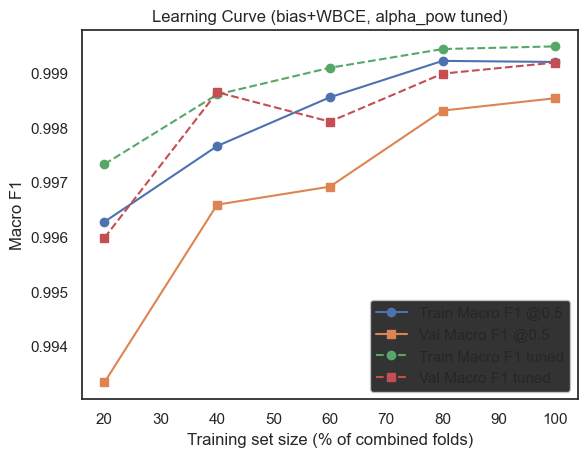

In [11]:

# Cross-val style summary
avg_val_metrics = {k: float(np.mean([m[k] for m in val_metrics])) for k in val_metrics[0]}
print("\nAblation Table (Averaged over Validation Folds):")
import pandas as pd
print(pd.DataFrame([avg_val_metrics]))

print(f"\nCV Macro F1 (mean over folds) @0.5 : {avg_val_metrics['Macro F1 @0.5']:.4f}")
print(f"CV Macro F1 (mean over folds) tuned: {avg_val_metrics['Macro F1 tuned']:.4f}")

# Classification report per fold
for i, fold in enumerate(folds):
    model_i = fold_models[i]
    probs = model_i.predict(get_inputs_list(fold['X_val']), verbose=0)
    y_pred = (probs > 0.5).astype(int)
    print(f"Fold {i+1} Classification Report:")
    print(classification_report(
        fold['Y_val'][targets].values,
        y_pred,
        target_names=targets,
        zero_division=0
    ))
# Learning curve (multilabel-stratified per size)

all_X = pd.concat([f['X_train'] for f in folds], axis=0).reset_index(drop=True)
all_Y = pd.concat([f['Y_train'] for f in folds], axis=0).reset_index(drop=True)

train_sizes = np.linspace(0.2, 1.0, 5)
lc_train_05, lc_val_05 = [], []
lc_train_tuned, lc_val_tuned = [], []

for seed, frac in enumerate(train_sizes, start=1):
    n = int(len(all_X) * frac)

    # Draw subset of size n with multilabel stratification
    # Guard prevents test_size=0 when frac == 1.0
    if n < len(all_X):
        msss = MLSSS(n_splits=1, test_size=len(all_X)-n, random_state=seed)
        (keep_idx, _), = msss.split(all_X.values, all_Y[targets].values)
        X_sub, Y_sub = all_X.iloc[keep_idx], all_Y.iloc[keep_idx]
    else:
        X_sub, Y_sub = all_X, all_Y

    # Internal 80/20 split with stratification
    msss2 = MLSSS(n_splits=1, test_size=0.2, random_state=seed)
    (tr_idx, va_idx), = msss2.split(X_sub.values, Y_sub[targets].values)
    X_tr, X_va = X_sub.iloc[tr_idx], X_sub.iloc[va_idx]
    Y_tr, Y_va = Y_sub.iloc[tr_idx], Y_sub.iloc[va_idx]

    # Priors/weights from TRAIN using best alpha_pow
    bias_vec, _, pi_vec = make_bias_and_alpha_from_df(Y_tr, targets)
    alpha_vec = (1.0 - pi_vec) ** best_params['alpha_pow']

    # Build & compile
    hidden_layer_sizes = (
        [best_params[f'units_l{i}'] for i in range(best_params['n_layers'])]
        if best_params['n_layers'] > 0 else []
    )
    lc_model = build_model(hidden_layer_sizes=hidden_layer_sizes, bias_init_value=bias_vec)
    lc_model.compile(
        optimizer=keras.optimizers.Adam(best_params['lr']),
        loss=weighted_bce(alpha_vec),
        metrics=[]
    )

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

    lc_model.fit(
        get_inputs_list(X_tr), Y_tr[targets].values,
        validation_data=(get_inputs_list(X_va), Y_va[targets].values),
        epochs=int(min(best_params['epochs'], 100)),
        batch_size=8,
        callbacks=[es], verbose=0,
    )

    # Train and val predictions
    train_probs = lc_model.predict(get_inputs_list(X_tr), verbose=0)
    val_probs   = lc_model.predict(get_inputs_list(X_va), verbose=0)
    ytr, yva    = Y_tr[targets].values, Y_va[targets].values

    # Macro-F1 @ 0.5
    lc_train_05.append(f1_score(ytr, (train_probs>=0.5).astype(int), average='macro', zero_division=0))
    lc_val_05.append(  f1_score(yva, (val_probs>=0.5).astype(int),   average='macro', zero_division=0))

    # Macro-F1 tuned
    th_vec = tune_thresholds_per_label(yva, val_probs, targets)
    lc_train_tuned.append(f1_score(ytr, apply_thresholds(train_probs, th_vec), average='macro', zero_division=0))
    lc_val_tuned.append(  f1_score(yva, apply_thresholds(val_probs,   th_vec), average='macro', zero_division=0))

plt.figure()
plt.plot(train_sizes*100, lc_train_05, marker='o', label='Train Macro F1 @0.5')
plt.plot(train_sizes*100, lc_val_05,   marker='s', label='Val Macro F1 @0.5')
plt.plot(train_sizes*100, lc_train_tuned, marker='o', linestyle='--', label='Train Macro F1 tuned')
plt.plot(train_sizes*100, lc_val_tuned,   marker='s', linestyle='--', label='Val Macro F1 tuned')
plt.xlabel('Training set size (% of combined folds)')
plt.ylabel('Macro F1')
plt.title('Learning Curve (bias+WBCE, alpha_pow tuned)')
plt.legend()
plt.show()

In [12]:
'''
# Optuna objective: Maximize macro F1 over k-fold validation
def objective(trial):
    # Hyperparameters to tune
    n_layers = trial.suggest_int('n_layers', 0,10)

    hidden_layer_sizes = [
        trial.suggest_int(f'units_l{i}', 256, 764, log=True)
        for i in range(n_layers)
    ]

    lr = trial.suggest_float('lr', 1e-6, 1e-1, log=True)
    alpha = trial.suggest_float('alpha', 0.1, 0.75)
    gamma = trial.suggest_float('gamma', 1, 4)
    initial_p = trial.suggest_float('initial_p', 0.00001, 0.002, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8,16,32,128,512])
    max_epochs = trial.suggest_int('epochs', 20, 350)

    # Adam hyperparams (kept tight so we don't go off the rails)
    beta_1 = trial.suggest_float('beta_1', 0.75, 0.99)
    beta_2 = trial.suggest_float('beta_2', 0.8, 0.999)
    epsilon = trial.suggest_float('epsilon', 1e-8, 1e-6, log=True)

    # convert p -> bias logit
    bias_init_value = np.log(initial_p / (1 - initial_p))

    macro_f1_scores = []

    try:
        for fold in folds:
            model = build_model(
                hidden_layer_sizes=hidden_layer_sizes,
                bias_init_value=bias_init_value
            )

            optimizer = keras.optimizers.Adam(
                learning_rate=lr,
                beta_1=beta_1,
                beta_2=beta_2,
                epsilon=epsilon,
            )

            loss = BinaryFocalCrossentropy(alpha=alpha, gamma=gamma,
                                           reduction='sum_over_batch_size',
                                           apply_class_balancing=True)

            model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=[
                    'accuracy',
                    AUC(name='roc_auc', curve='ROC', multi_label=True),
                    AUC(name='pr_auc', curve='PR', multi_label=True),
                ],
            )

            es = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                mode='min'
            )

            model.fit(
                get_inputs_list(fold['X_train']),
                fold['Y_train'][targets].values,
                validation_data=(
                    get_inputs_list(fold['X_val']),
                    fold['Y_val'][targets].values
                ),
                epochs=max_epochs,
                batch_size=batch_size,
                callbacks=[es],
                verbose=0,
            )

            probs = model.predict(
                get_inputs_list(fold['X_val']),
                verbose=0
            )
            y_pred = (probs > 0.5).astype(int)

            macro_f1 = f1_score(
                fold['Y_val'][targets].values,
                y_pred,
                average='macro'
            )
            macro_f1_scores.append(macro_f1)

        mean_macro_f1 = float(np.mean(macro_f1_scores))

        # Log per-trial diagnostics into Optuna (shows up in dashboard/user_attrs)
        trial.set_user_attr("mean_macro_f1", mean_macro_f1)
        trial.set_user_attr("macro_f1_per_fold", macro_f1_scores)

        return mean_macro_f1

    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        raise optuna.TrialPruned()


# Run Optuna study with storage for dashboard
storage = "sqlite:///db.sqlite3"

study = optuna.create_study(
    direction='maximize',
    study_name='multi_label-enabled-BFL-balancing',
    storage=storage,
    load_if_exists=True
)
study.optimize(objective, n_trials=50)

# Visualizations (skip importances if variance is zero)
plot_optimization_history(study).show()
try:
    plot_param_importances(study).show()
except RuntimeError as e:
    print(f"Skipping param_importances due to zero variance: {e}")
plot_slice(study).show()

# Best parameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# =========================
# Retrain with best params
# =========================
val_metrics = []
histories = []
fold_models = []  # keep per-fold models for proper CV-style eval

for fold in folds:
    initial_p = best_params['initial_p']
    bias_init_value = np.log(initial_p / (1 - initial_p))

    hidden_layer_sizes = (
        [
            best_params[f'units_l{i}']
            for i in range(best_params['n_layers'])
        ]
        if best_params['n_layers'] > 0
        else []
    )

    model = build_model(
        hidden_layer_sizes=hidden_layer_sizes,
        bias_init_value=bias_init_value
    )

    optimizer = keras.optimizers.Adam(
        learning_rate=best_params['lr'],
        beta_1=best_params.get('beta_1', 0.9),
        beta_2=best_params.get('beta_2', 0.999),
        epsilon=best_params.get('epsilon', 1e-7),
    )

    loss = BinaryFocalCrossentropy(
        alpha=best_params['alpha'],
        gamma=best_params['gamma']
    )

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            'accuracy',
            AUC(name='roc_auc', curve='ROC', multi_label=True),
            AUC(name='pr_auc', curve='PR', multi_label=True),
        ],
    )

    es = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        mode='min'
    )

    history = model.fit(
        get_inputs_list(fold['X_train']),
        fold['Y_train'][targets].values,
        validation_data=(
            get_inputs_list(fold['X_val']),
            fold['Y_val'][targets].values
        ),
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        callbacks=[es],
        verbose=0,
    )

    histories.append(history)
    fold_models.append(model)

    probs = model.predict(get_inputs_list(fold['X_val']), verbose=0)
    y_true = fold['Y_val'][targets].values
    y_pred = (probs > 0.5).astype(int)

    val_loss = history.history['val_loss'][-1]

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    pr_auc = average_precision_score(y_true, probs, average='macro')

    # Handle possible no-positive-label edge cases for ROC_AUC
    try:
        roc_auc = roc_auc_score(y_true, probs, average='macro')
    except ValueError:
        roc_auc = np.nan

    recall_pos = recall_score(y_true, y_pred, average='macro', zero_division=0)
    precision_pos = precision_score(y_true, y_pred, average='macro', zero_division=0)

    val_metrics.append({
        'Categorical Focal Cross Entropy': val_loss,
        'Macro F1': macro_f1,
        'Micro F1': micro_f1,
        'PR_AUC': pr_auc,
        'ROC_AUC': roc_auc,
        'Recall Positive': recall_pos,
        'Precision Positive': precision_pos,
        'focal-loss alpha': best_params['alpha'],
        'focal-loss gamma': best_params['gamma'],
        'bias initializer': bias_init_value,
        'Learning_rate': best_params['lr'],
        'batch_size': best_params['batch_size'],
        'epochs': best_params['epochs'],
    })

# =========================
# Cross-val style summary
# =========================
avg_val_metrics = {
    k: np.mean([m[k] for m in val_metrics])
    for k in val_metrics[0]
}
ablation_df = pd.DataFrame([avg_val_metrics])
print("Ablation Table (Averaged over Validation Folds):")
print(ablation_df)

# Treat these as your cross_val_score-style metrics
cv_macro_f1 = avg_val_metrics['Macro F1']
cv_micro_f1 = avg_val_metrics['Micro F1']
print(f"CV Macro F1 (mean over folds): {cv_macro_f1:.4f}")
print(f"CV Micro F1 (mean over folds): {cv_micro_f1:.4f}")

# =========================
# Classification report per fold
# (using the correct model per fold)
# =========================
for i, fold in enumerate(folds):
    model_i = fold_models[i]
    probs = model_i.predict(get_inputs_list(fold['X_val']), verbose=0)
    y_pred = (probs > 0.5).astype(int)
    print(f"Fold {i+1} Classification Report:")
    print(classification_report(
        fold['Y_val'][targets].values,
        y_pred,
        target_names=targets,
        zero_division=0
    ))

# =========================
# Learning curve (custom, Keras-friendly)
# =========================
# We'll use all training folds combined, and for each train_size
# train a fresh model with best_params and evaluate on a held-out chunk.

all_X = pd.concat([f['X_train'] for f in folds], axis=0).reset_index(drop=True)
all_Y = pd.concat([f['Y_train'] for f in folds], axis=0).reset_index(drop=True)

train_sizes = np.linspace(0.2, 1.0, 5)
lc_train_scores = []
lc_val_scores = []

for frac in train_sizes:
    n_samples = int(len(all_X) * frac)

    X_sub = all_X.iloc[:n_samples]
    Y_sub = all_Y.iloc[:n_samples]

    # simple internal split: 80% train, 20% val
    split = int(n_samples * 0.8)
    X_tr, X_va = X_sub.iloc[:split], X_sub.iloc[split:]
    Y_tr, Y_va = Y_sub.iloc[:split], Y_sub.iloc[split:]

    # build model with best_params
    initial_p = best_params['initial_p']
    bias_init_value = np.log(initial_p / (1 - initial_p))

    hidden_layer_sizes = (
        [
            best_params[f'units_l{i}']
            for i in range(best_params['n_layers'])
        ]
        if best_params['n_layers'] > 0
        else []
    )

    lc_model = build_model(
        hidden_layer_sizes=hidden_layer_sizes,
        bias_init_value=bias_init_value
    )

    lc_optimizer = keras.optimizers.Adam(
        learning_rate=best_params['lr'],
        beta_1=best_params.get('beta_1', 0.9),
        beta_2=best_params.get('beta_2', 0.999),
        epsilon=best_params.get('epsilon', 1e-7),
    )

    lc_loss = BinaryFocalCrossentropy(
        alpha=best_params['alpha'],
        gamma=best_params['gamma']
    )

    lc_model.compile(
        optimizer=lc_optimizer,
        loss=lc_loss,
        metrics=['accuracy'],
    )

    lc_es = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        mode='min'
    )

    lc_model.fit(
        get_inputs_list(X_tr),
        Y_tr[targets].values,
        validation_data=(get_inputs_list(X_va), Y_va[targets].values),
        epochs=int(min(best_params['epochs'], 100)),  # cap for speed
        batch_size=int(best_params['batch_size']),
        callbacks=[lc_es],
        verbose=0,
    )

    # F1 on train + val subsets
    train_probs = lc_model.predict(get_inputs_list(X_tr), verbose=0)
    val_probs = lc_model.predict(get_inputs_list(X_va), verbose=0)

    train_pred = (train_probs > 0.5).astype(int)
    val_pred = (val_probs > 0.5).astype(int)

    lc_train_scores.append(
        f1_score(Y_tr[targets].values, train_pred, average='macro')
    )
    lc_val_scores.append(
        f1_score(Y_va[targets].values, val_pred, average='macro')
    )

plt.figure()
plt.plot(train_sizes * 100, lc_train_scores, marker='o', label='Train Macro F1')
plt.plot(train_sizes * 100, lc_val_scores, marker='s', label='Val Macro F1')
plt.xlabel('Training set size (% of combined folds)')
plt.ylabel('Macro F1')
plt.title('Learning Curve (best configuration)')
plt.legend()
plt.show()

# =========================
# Confusion matrices (multi-label, out-of-fold)
# =========================
# Use all validation predictions from their own fold models -> proper CV-style
all_val_true = []
all_val_pred = []

for i, fold in enumerate(folds):
    model_i = fold_models[i]
    probs = model_i.predict(get_inputs_list(fold['X_val']), verbose=0)
    y_true = fold['Y_val'][targets].values
    y_pred = (probs > 0.5).astype(int)
    all_val_true.append(y_true)
    all_val_pred.append(y_pred)

all_val_true = np.vstack(all_val_true)
all_val_pred = np.vstack(all_val_pred)

ml_cm = multilabel_confusion_matrix(all_val_true, all_val_pred)

print("\nMulti-label confusion matrices per target (out-of-fold):")
for idx, label in enumerate(targets):
    tn, fp, fn, tp = ml_cm[idx].ravel()
    print(f"\nLabel: {label}")
    print(f"TN={tn} FP={fp} FN={fn} TP={tp}")

'''

'\n# Optuna objective: Maximize macro F1 over k-fold validation\ndef objective(trial):\n    # Hyperparameters to tune\n    n_layers = trial.suggest_int(\'n_layers\', 0,10)\n\n    hidden_layer_sizes = [\n        trial.suggest_int(f\'units_l{i}\', 256, 764, log=True)\n        for i in range(n_layers)\n    ]\n\n    lr = trial.suggest_float(\'lr\', 1e-6, 1e-1, log=True)\n    alpha = trial.suggest_float(\'alpha\', 0.1, 0.75)\n    gamma = trial.suggest_float(\'gamma\', 1, 4)\n    initial_p = trial.suggest_float(\'initial_p\', 0.00001, 0.002, log=True)\n    batch_size = trial.suggest_categorical(\'batch_size\', [8,16,32,128,512])\n    max_epochs = trial.suggest_int(\'epochs\', 20, 350)\n\n    # Adam hyperparams (kept tight so we don\'t go off the rails)\n    beta_1 = trial.suggest_float(\'beta_1\', 0.75, 0.99)\n    beta_2 = trial.suggest_float(\'beta_2\', 0.8, 0.999)\n    epsilon = trial.suggest_float(\'epsilon\', 1e-8, 1e-6, log=True)\n\n    # convert p -> bias logit\n    bias_init_value = n